## Import Data

In [7]:
!ls .././data | sort

busstops_norway.csv
grunnkrets_age_distribution.csv
grunnkrets_households_num_persons.csv
grunnkrets_income_households.csv
grunnkrets_norway_stripped.csv
plaace_hierarchy.csv
sample_submission.csv
stores_extra.csv
stores_test.csv
stores_train.csv


## Libraries

In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing

## Settings

In [60]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
plt.figure(figsize=(9, 7))
plt.style.use('bmh')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

plt.rc('font', **font)

<Figure size 900x700 with 0 Axes>

## Import Files

In [10]:
stores_train = pd.read_csv('../data/stores_train.csv')
stores_test = pd.read_csv('../data/stores_test.csv')
stores_extra = pd.read_csv('../data/stores_extra.csv')
plaace_hierarchy = pd.read_csv('../data/plaace_hierarchy.csv')
grunnkrets = pd.read_csv('../data/grunnkrets_norway_stripped.csv')
grunnkrets_ages = pd.read_csv('../data/grunnkrets_age_distribution.csv')
grunnkrets_household_types = pd.read_csv('../data/grunnkrets_households_num_persons.csv')
grunnkrets_household_income = pd.read_csv('../data/grunnkrets_income_households.csv')
busstops = pd.read_csv('../data/busstops_norway.csv')

## RMSLE Function

In [11]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

# Merging all the Datasets

## Merging plaace_hierarchy with Stores data

In [12]:
# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_with_hierarchy_test = stores_test.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

# Show dataframe, but transposed so that we can more easily see all the resulting columns
stores_with_hierarchy.head()

store_id  year                           store_name  \
0   983540538-974187930-44774  2016  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755  2016           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491  2016                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912  2016        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469  2016             BURGER KING TILLERTORGET   

  plaace_hierarchy_id   sales_channel_name_x  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue   sales_channel_name_y  lv1                lv1_desc  lv2  \
0   17.998  Hamburger restaurants    1  Dining and Experiences  1.1   
1   23.828  Hamburger restaurants    1  Dining and Experiences  1.1   
2   16.099  Hamburger restaurants    1  Dining and Experiences  1.1   
3    9.296  Hamburger restaurants    1  Dining and Experiences  1.1   
4    4.528  Hamburger restaurants    1  Dining and Experiences  1.1   

     lv2_desc    lv3               lv3_desc      lv4               lv4_desc  
0  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
1  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
2  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
3  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
4  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants

## Merging Grunnkrets with Stores data

In [13]:
grunnkrets_2016 = grunnkrets.loc[grunnkrets['year'] == 2016]
stores_with_hierarchy_grunnkrets = pd.merge(stores_with_hierarchy, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test = pd.merge(stores_with_hierarchy_test, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test


store_id  year_x                    store_name  \
0     914206820-914239427-717245    2016     VÅLERENGA HALAL BURGER AS   
1     916789157-916823770-824309    2016             BURGER KING MYREN   
2       913341082-977479363-2948    2016           BURGER KING STOVNER   
3      889682582-889697172-28720    2016       BURGER KING TUNGASLETTA   
4     997991699-998006945-417222    2016              VULKAN BURGERBAR   
...                          ...     ...                           ...   
8572  917323003-917383529-844309    2016            GULATING HAUGESUND   
8573  917353379-917411824-845904    2016             STAVANGER BEER AS   
8574  917072302-917089248-833647    2016      GULATING ØLUTSALG OG PUB   
8575  916960557-916993161-829908    2016     VI BRYGGER BUTIKKDRIFT AS   
8576   987280891-972040746-45320    2016  KROKEN ØL OG MINERALVANN ANS   

     plaace_hierarchy_id   sales_channel_name_x  grunnkrets_id  \
0                1.1.1.0  Hamburger restaurants        3012704   
1                1.1.1.0  Hamburger restaurants        8061401   
2                1.1.1.0  Hamburger restaurants        3013917   
3                1.1.1.0  Hamburger restaurants       16012104   
4                1.1.1.0  Hamburger restaurants        3014305   
...                  ...                    ...            ...   
8572            2.8.11.2     Beer and soda shop       11490601   
8573            2.8.11.2     Beer and soda shop       11030901   
8574            2.8.11.2     Beer and soda shop        2270103   
8575            2.8.11.2     Beer and soda shop       12470701   
8576            2.8.11.2     Beer and soda shop        8170207   

                     address        lat        lon        chain_name  \
0           STRØMSVEIEN 25 A  59.908672  10.787031               NaN   
1                    MYREN 1  59.201467   9.588243       BURGER KING   
2           STOVNER SENTER 3  59.962146  10.924524       BURGER KING   
3             TUNGASLETTA 16  63.420785  10.461091       BURGER KING   
4     AUD SCHØNEMANNS VEI 15  59.921102  10.785123  VULKAN BURGERBAR   
...                      ...        ...        ...               ...   
8572           BRÅTAVEGEN 30  59.259575   5.325813  GULATING GRUPPEN   
8573              SANDVIGÅ 7  58.976219   5.721546               NaN   
8574          GARDERBAKKEN 6  59.928330  11.163202  GULATING GRUPPEN   
8575          RAVNANGERVEGEN  60.445790   5.161587               NaN   
8576                     NaN  59.097903   9.055490               NaN   

           mall_name   sales_channel_name_y  lv1                lv1_desc  lv2  \
0                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
1                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
2     Stovner Senter  Hamburger restaurants    1  Dining and Experiences  1.1   
3                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
4                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
...              ...                    ...  ...                     ...  ...   
8572             NaN     Beer and soda shop    2                  Retail  2.8   
8573             NaN     Beer and soda shop    2                  Retail  2.8   
8574             NaN     Beer and soda shop    2                  Retail  2.8   
8575             NaN     Beer and soda shop    2                  Retail  2.8   
8576             NaN     Beer and soda shop    2                  Retail  2.8   

             lv2_desc     lv3               lv3_desc       lv4  \
0          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
2          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
3          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
4          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
...               ...     ...                    ...       ...   
8572  Food and drinks  2.8.11          Alc

In [14]:
grunnkrets_ages
grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age

# Feature engineering: Age binning
under_18 = grunnkrets_ages.loc[: , "age_0":"age_18"]
ages_19_to_30 = grunnkrets_ages.loc[: , "age_19":"age_30"]
ages_31_to_45 = grunnkrets_ages.loc[: , "age_31":"age_45"]
ages_46_to_60 = grunnkrets_ages.loc[: , "age_46":"age_60"]
ages_61_to_90 = grunnkrets_ages.loc[: , "age_61":"age_90"]


grunnkrets_ages['0_to_18'] = under_18.sum(axis = 1)
grunnkrets_ages['19_to_30'] = ages_19_to_30.sum(axis = 1)
grunnkrets_ages['31_to_45'] = ages_31_to_45.sum(axis = 1)
grunnkrets_ages['46_to_60'] = ages_46_to_60.sum(axis = 1)
grunnkrets_ages['61_to_90'] = ages_61_to_90.sum(axis = 1)
grunnkrets_ages = grunnkrets_ages.drop(grunnkrets_ages.iloc[:, 2:93],axis = 1) # drop age columns

grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age['0_to_18'] = stores_with_hierarchy_grunnkrets_age['0_to_18'].fillna((stores_with_hierarchy_grunnkrets_age['0_to_18'].mean()))
stores_with_hierarchy_grunnkrets_age['19_to_30'] = stores_with_hierarchy_grunnkrets_age['19_to_30'].fillna((stores_with_hierarchy_grunnkrets_age['19_to_30'].mean()))
stores_with_hierarchy_grunnkrets_age['31_to_45'] = stores_with_hierarchy_grunnkrets_age['31_to_45'].fillna((stores_with_hierarchy_grunnkrets_age['31_to_45'].mean()))
stores_with_hierarchy_grunnkrets_age['46_to_60'] = stores_with_hierarchy_grunnkrets_age['46_to_60'].fillna((stores_with_hierarchy_grunnkrets_age['46_to_60'].mean()))
stores_with_hierarchy_grunnkrets_age['61_to_90'] = stores_with_hierarchy_grunnkrets_age['61_to_90'].fillna((stores_with_hierarchy_grunnkrets_age['61_to_90'].mean()))


In [15]:
grunnkrets_household_types
grunnkrets_household_types_2016 = grunnkrets_household_types.loc[grunnkrets_household_types['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes = pd.merge(stores_with_hierarchy_grunnkrets_age, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_test = pd.merge(stores_with_hierarchy_grunnkrets_age_test, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes


/tmp/ipykernel_1007330/2204752244.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'year_x'} in the result is deprecated and will raise a MergeError in a future version.
  stores_with_hierarchy_grunnkrets_age_hhtypes = pd.merge(stores_with_hierarchy_grunnkrets_age, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')
/tmp/ipykernel_1007330/2204752244.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'year_x'} in the result is deprecated and will raise a MergeError in a future version.
  stores_with_hierarchy_grunnkrets_age_hhtypes_test = pd.merge(stores_with_hierarchy_grunnkrets_age_test, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')


store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

In [16]:
grunnkrets_household_income
grunnkrets_household_income_2016 = grunnkrets_household_income.loc[grunnkrets_household_income['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes_test, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome


store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

In [17]:
stores_train_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome
stores_test_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test
stores_train_merged

store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

# Exploratory Data Analysis

In [18]:
df = stores_train_merged
df


store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

In [19]:
# Ignore first
# s = df.pop('revenue') 
# new_df = pd.concat([df, s], 1)
# new_df
new_df = df


### Seperate the data set into numerical and categorical data

In [20]:
df_numerical_features = new_df.select_dtypes(exclude='object')
df_categorical_features = new_df.select_dtypes(include='object')
df_numerical_features

year_x  grunnkrets_id        lat        lon  revenue  lv1  lv2  year_y  \
0        2016        6020303  59.743104  10.204928   17.998    1  1.1  2016.0   
1        2016        3010306  59.913759  10.734031   23.828    1  1.1  2016.0   
2        2016        6050102  60.164751  10.254656   16.099    1  1.1  2016.0   
3        2016       18040102  67.283669  14.379796    9.296    1  1.1  2016.0   
4        2016       16017414  63.358068  10.374832    4.528    1  1.1  2016.0   
...       ...            ...        ...        ...      ...  ...  ...     ...   
12854    2016        7010705  59.416276  10.480970    0.088    2  2.8  2016.0   
12855    2016        5020406  60.799991  10.693635    1.816    2  2.8  2016.0   
12856    2016        2310803  59.946562  11.007659   38.225    2  2.8  2016.0   
12857    2016       11020113  58.850261   5.735674    3.642    2  2.8  2016.0   
12858    2016       19021302  69.670422  19.042659    2.328    2  2.8  2016.0   

       area_km2  year_x     0_to_18    19_to_30    31_to_45    46_to_60  \
0      0.155779  2016.0   25.000000   44.000000   43.000000   23.000000   
1      0.264278     NaN  143.178518  147.850889  167.610733  130.408457   
2      0.160152  2016.0   67.000000  103.000000   76.000000   45.000000   
3      0.095029  2016.0   46.000000  109.000000  134.000000   89.000000   
4      0.251070     NaN  143.178518  147.850889  167.610733  130.408457   
...         ...     ...         ...         ...         ...         ...   
12854  0.291337  2016.0  194.000000  221.000000  257.000000  251.000000   
12855  0.137188  2016.0   42.000000  155.000000  104.000000   84.000000   
12856  0.123431  2016.0  145.000000  279.000000  229.000000  162.000000   
12857  0.034857  2016.0   22.000000   72.000000   67.000000   39.000000   
12858  0.204915  2016.0  238.000000  147.000000  246.000000  248.000000   

         61_to_90  year_y  couple_children_0_to_5_years  \
0       22.000000  2016.0                          20.0   
1      176.302127  2016.0                           0.0   
2       81.000000  2016.0                          45.0   
3       96.000000  2016.0                          41.0   
4      176.302127  2016.0                           0.0   
...           ...     ...                           ...   
12854  593.000000  2016.0                         159.0   
12855  118.000000  2016.0                          47.0   
12856  302.000000  2016.0                         147.0   
12857   81.000000  2016.0                          22.0   
12858  271.000000  2016.0                         255.0   

       couple_children_18_or_above  couple_children_6_to_17_years  \
0                              0.0                            8.0   
1                              0.0                            0.0   
2                              9.0                           38.0   
3                             10.0                           27.0   
4                              0.0                            0.0   
...                            ...                            ...   
12854                         53.0                          113.0   
12855                          9.0                           14.0   
12856                         30.0                           76.0   
12857                          0.0                            7.0   
12858                         47.0                          135.0   

       couple_without_children_x  single_parent_children_0_to_5_years  \
0                           28.0                                  4.0   
1                            0.0                                  0.0   
2                           84.0                                 13.0   
3                          126.0                                 11.0   
4                            0.0                                  0.0   
...                          ...                                  ...   
12854                      488.0                                 46.0   
12855      

## Distribution of Revenue

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


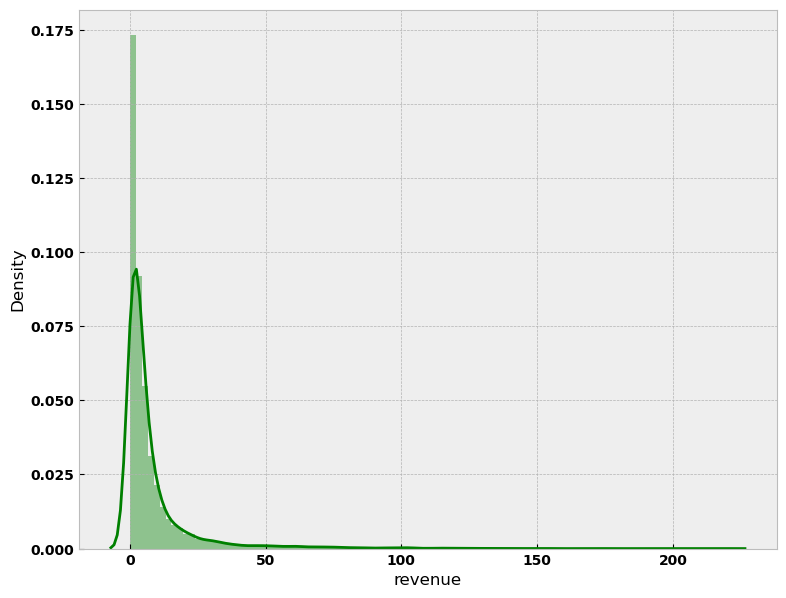

In [57]:
plt.figure(figsize=(9, 7))
sns.distplot(df['revenue'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical Data Distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


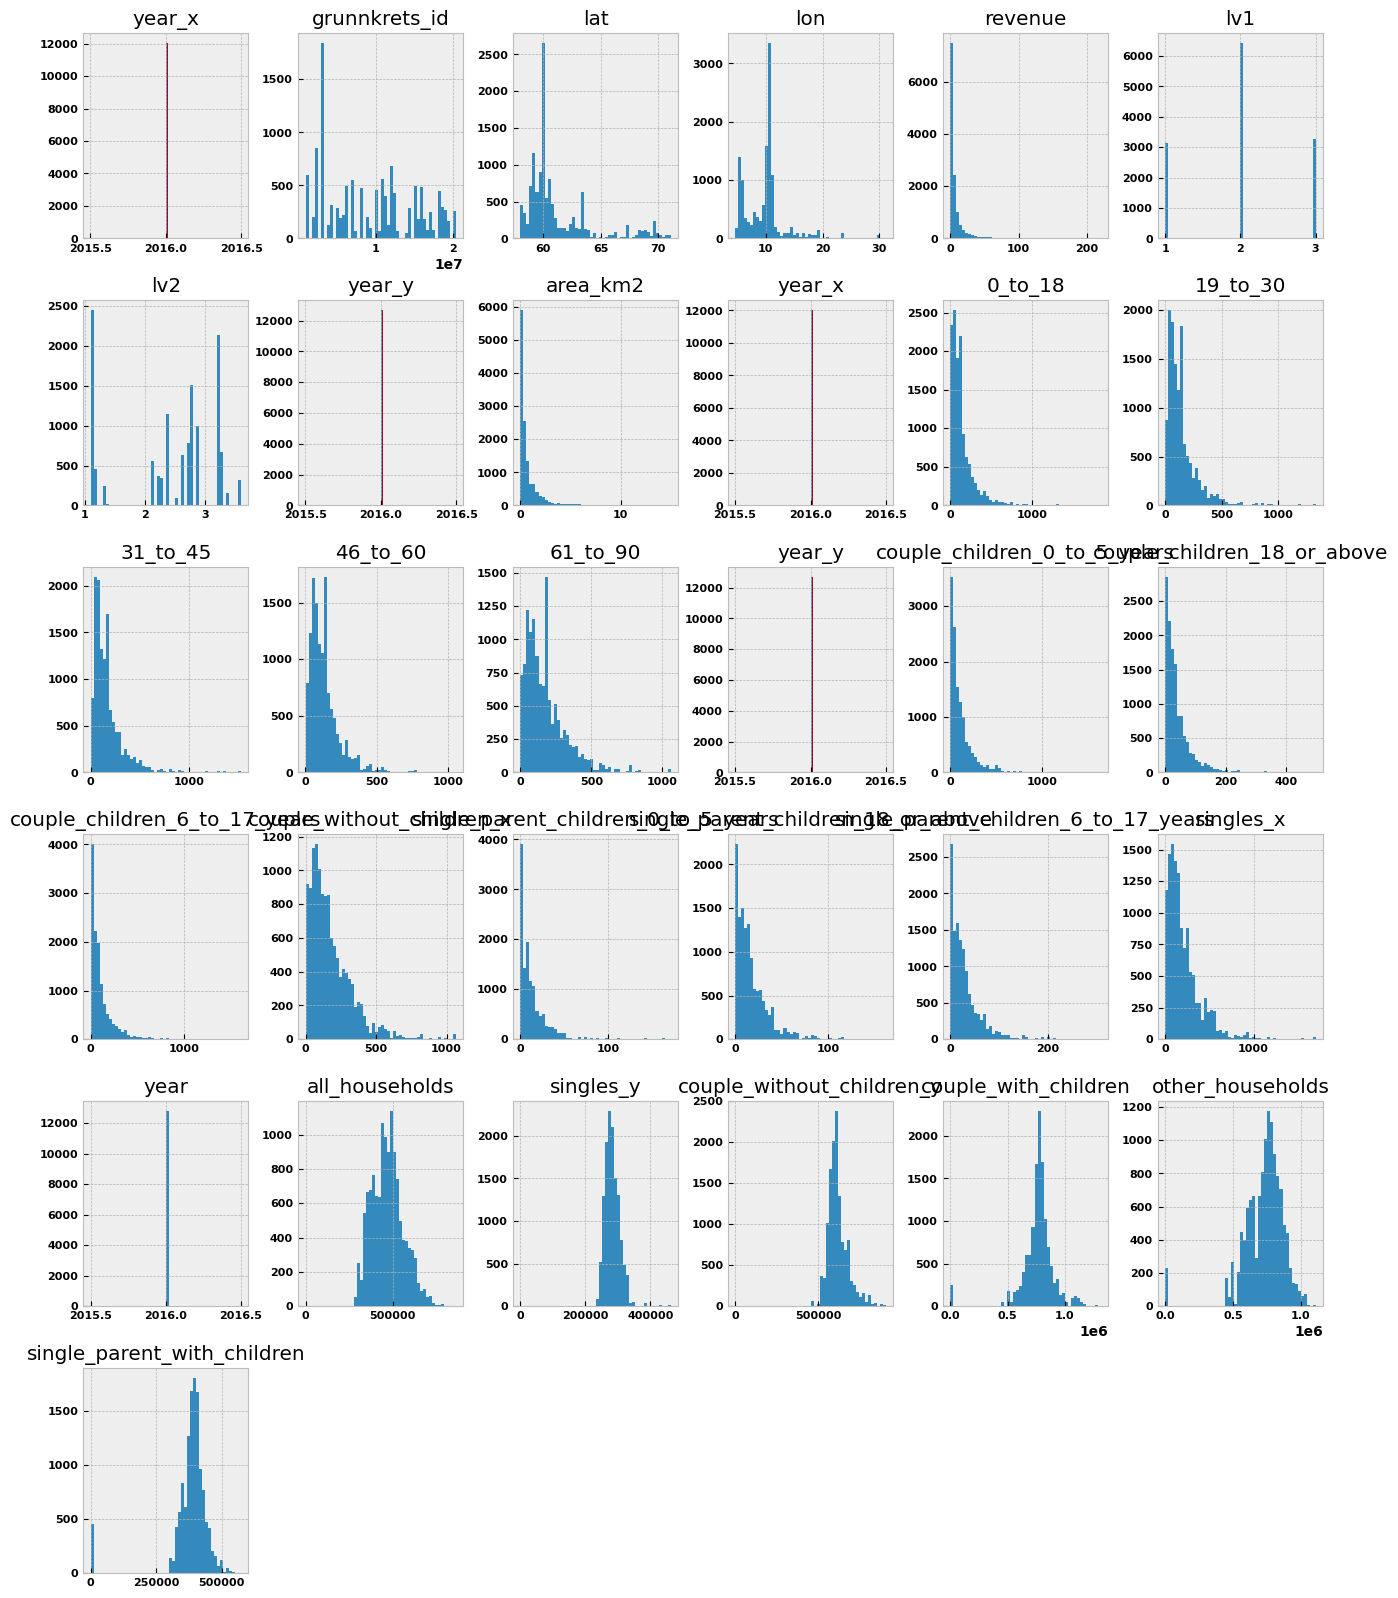

In [58]:
df_numerical_features.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 

## Correlation with Revenue

In [23]:
df_num_corr = df_numerical_features.corr()['revenue'][:-1] # -1 because the latest row is SalePrice
df_num_corr
golden_features_list = df_num_corr[abs(df_num_corr) > 0.00].sort_values(ascending=False)
print("The top {} correlated values with revenue are:\n{}".format(len(golden_features_list), golden_features_list))

The top 25 correlated values with revenue are:
revenue                                 1.000000
all_households                          0.037117
singles_y                               0.034573
lv2                                     0.021941
0_to_18                                 0.021079
other_households                        0.020773
couple_children_6_to_17_years           0.016798
couple_with_children                    0.014701
grunnkrets_id                           0.014588
area_km2                                0.013703
couple_children_0_to_5_years            0.012815
couple_without_children_y               0.012283
couple_children_18_or_above             0.011553
single_parent_children_18_or_above      0.011551
46_to_60                                0.010707
single_parent_children_6_to_17_years    0.008844
lat                                     0.007547
31_to_45                                0.007052
lon                                     0.003112
19_to_30              

## Feature to Feature Correlation

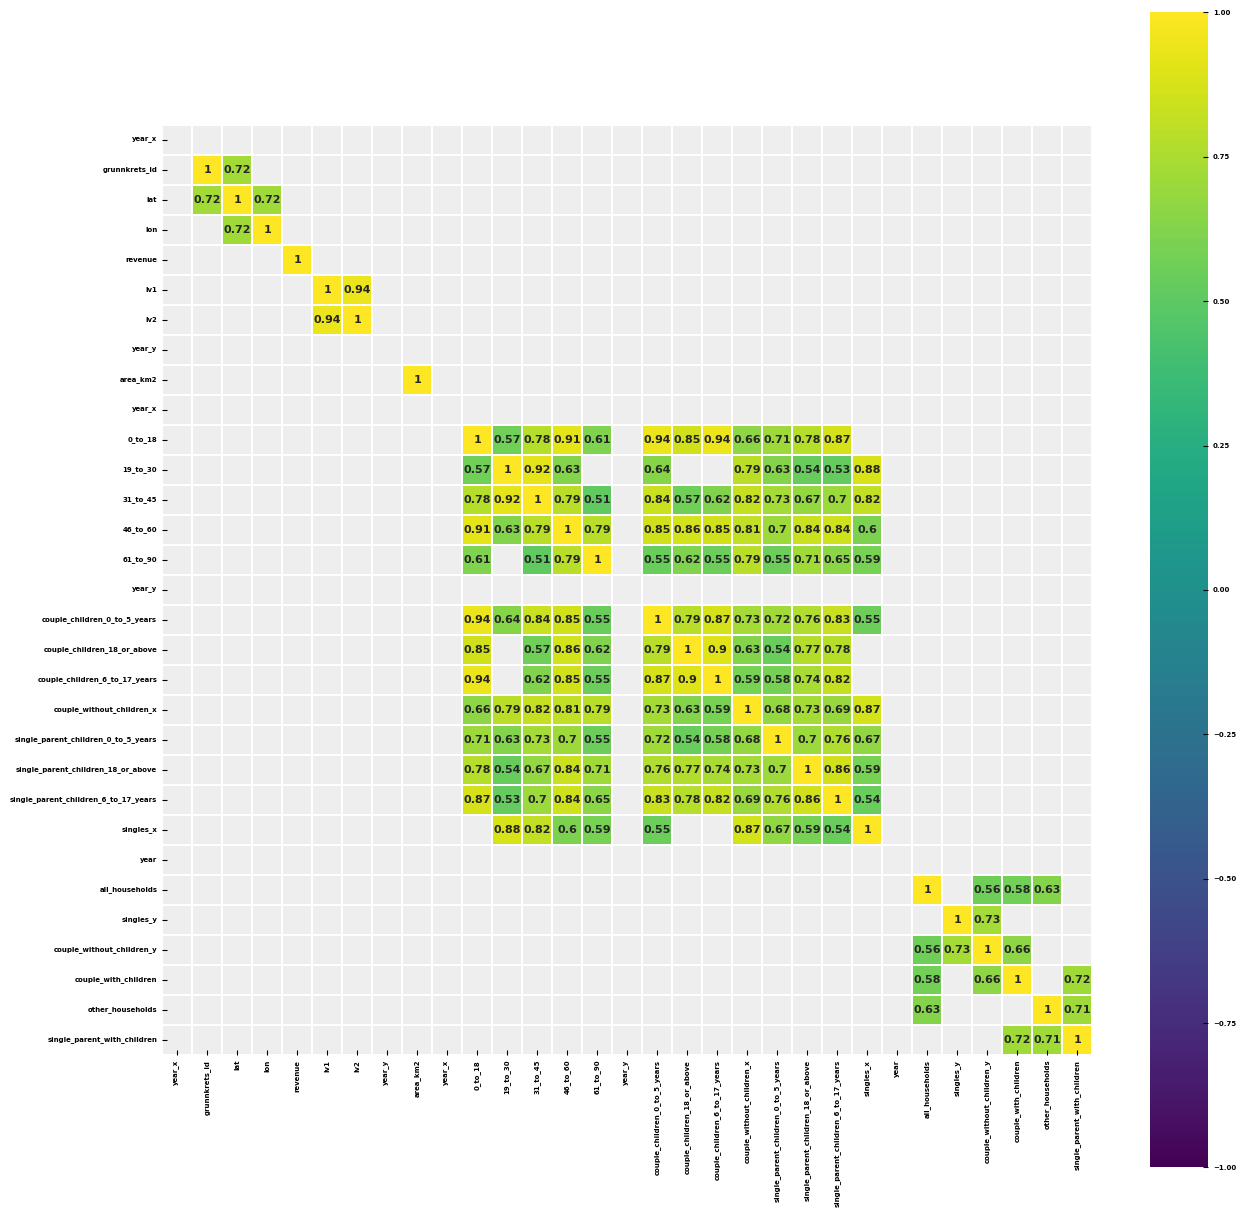

In [65]:
plt.figure(figsize=(15,15))
c= df.corr()
sns.heatmap(c[(c >= 0.5) | (c <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [67]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

/tmp/ipykernel_1007330/1690873751.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['year_x',
 'lv2',
 'year_y',
 'year_x',
 '31_to_45',
 '46_to_60',
 'year_y',
 'couple_children_0_to_5_years',
 'couple_children_6_to_17_years']

# Feature Engineering

## 1. Dropping Redundant & Highly Correlated Columns

In [68]:
stores_train_finalcols = stores_train_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry', '31_to_45', '46_to_60','couple_children_0_to_5_years', 'couple_children_6_to_17_years'])

stores_test_finalcols = stores_test_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry', '31_to_45', '46_to_60','couple_children_0_to_5_years', 'couple_children_6_to_17_years'])

## 2. One Hot Encoding - Do not need to run this part anymore for LightGBM & CatBoost

### Using LabelEncoder

In [ ]:
#categorical data
label_encoder = preprocessing.LabelEncoder()
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

### Using Get_Dummies

In [ ]:
#categorical data
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

#import pandas as pd
df_res_onehot = pd.get_dummies(df_res, columns = categorical_cols)
stores_train_finalcols_onehot = df_res_onehot.iloc[:12859]
stores_test_finalcols_onehot = df_res_onehot.iloc[12859:]

stores_test_finalcols_onehot

## 3. Handling Outliers

In [ ]:
#Dropping the outlier rows with Percentiles - Run this if you are using One Hot Encoder
# upper_lim = stores_train_finalcols_onehot['revenue'].quantile(.95)
# lower_lim = stores_train_finalcols_onehot['revenue'].quantile(.05)

# stores_train_finalcols_onehot = stores_train_finalcols_onehot[(stores_train_finalcols_onehot['revenue'] < upper_lim) & (stores_train_finalcols_onehot['revenue'] > lower_lim)]
# X_train = stores_train_finalcols_onehot.drop(columns=['revenue', 'store_id'])
# y_train = stores_train_finalcols_onehot.revenue 
# X_test = stores_test_finalcols_onehot.drop(columns=['store_id'])
# X_train


In [69]:
#Dropping the outlier rows with Percentiles - Run this if NOT using One Hot Encoder
upper_lim = stores_train_finalcols['revenue'].quantile(.95)
lower_lim = stores_train_finalcols['revenue'].quantile(.05)

stores_train_finalcols = stores_train_finalcols[(stores_train_finalcols['revenue'] < upper_lim) & (stores_train_finalcols['revenue'] > lower_lim)]
X_train = stores_train_finalcols.drop(columns=['revenue', 'store_id'])
y_train = stores_train_finalcols.revenue 
X_test = stores_test_finalcols.drop(columns=['store_id'])

#Imputing missing values for both train and test
X_train.fillna(-999, inplace=True)
X_test.fillna(-999,inplace=True)

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

/tmp/ipykernel_1007330/3404883441.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_train.dtypes != np.float)[0]


array([ 0,  3,  4,  5,  6,  7,  8,  9, 10])

# Models

## Model 1 - catBoost

### Log Revenue Value to Match Loss Function RMSE

In [70]:
y_train_log = np.log(y_train)
y_train_log

0        2.890261
1        3.170861
2        2.778757
3        2.229584
4        1.510280
           ...   
12852    0.064851
12853    1.049772
12855    0.596636
12857    1.292533
12858    0.845010
Name: revenue, Length: 11572, dtype: float64

### Do Internal Split

In [71]:
X_train

sales_channel_name_x        lat        lon        chain_name  \
0      Hamburger restaurants  59.743104  10.204928         MCDONALDS   
1      Hamburger restaurants  59.913759  10.734031         MCDONALDS   
2      Hamburger restaurants  60.164751  10.254656       BURGER KING   
3      Hamburger restaurants  67.283669  14.379796       BURGER KING   
4      Hamburger restaurants  63.358068  10.374832       BURGER KING   
...                      ...        ...        ...               ...   
12852     Beer and soda shop  59.794367  10.822117              -999   
12853     Beer and soda shop  60.143874  11.166341              -999   
12855     Beer and soda shop  60.799991  10.693635  GULATING GRUPPEN   
12857     Beer and soda shop  58.850261   5.735674              -999   
12858     Beer and soda shop  69.670422  19.042659              -999   

               mall_name   sales_channel_name_y                lv1_desc  \
0      Magasinet Drammen  Hamburger restaurants  Dining and Experiences   
1                   -999  Hamburger restaurants  Dining and Experiences   
2         Kuben Hønefoss  Hamburger restaurants  Dining and Experiences   
3      Glasshuspassasjen  Hamburger restaurants  Dining and Experiences   
4           Tillertorget  Hamburger restaurants  Dining and Experiences   
...                  ...                    ...                     ...   
12852               -999     Beer and soda shop                  Retail   
12853               -999     Beer and soda shop                  Retail   
12855          CC Gjøvik     Beer and soda shop                  Retail   
12857        Bystasjonen     Beer and soda shop                  Retail   
12858               -999     Beer and soda shop                  Retail   

              lv2_desc               lv3_desc               lv4_desc  \
0           Restaurant  Hamburger restaurants  Hamburger restaurants   
1           Restaurant  Hamburger restaurants  Hamburger restaurants   
2           Restaurant  Hamburger restaurants  Hamburger restaurants   
3           Restaurant  Hamburger restaurants  Hamburger restaurants   
4           Restaurant  Hamburger restaurants  Hamburger restaurants   
...                ...                    ...                    ...   
12852  Food and drinks          Alcohol sales     Beer and soda shop   
12853  Food and drinks          Alcohol sales     Beer and soda shop   
12855  Food and drinks          Alcohol sales     Beer and soda shop   
12857  Food and drinks          Alcohol sales     Beer and soda shop   
12858  Food and drinks          Alcohol sales     Beer and soda shop   

      municipality_name  area_km2     0_to_18    19_to_30    61_to_90  \
0               Drammen  0.155779   25.000000   44.000000   22.000000   
1                  Oslo  0.264278  143.178518  147.850889  176.302127   
2             Ringerike  0.160152   67.000000  103.000000   81.000000   
3                  Bodø  0.095029   46.000000  109.000000   96.000000   
4             Trondheim  0.251070  143.178518  147.850889  176.302127   
...                 ...       ...         ...         ...         ...   
12852          Oppegård  0.485874  143.178518  147.850889  176.302127   
12853        Ullensaker  0.718623  167.000000  327.000000  762.000000   
12855            Gjøvik  0.137188   42.000000  155.000000  118.000000   
12857           Sandnes  0.034857   22.000000   72.000000   81.000000   
12858            Tromsø  0.204915  238.000000  147.000000  271.000000   

       couple_children_18_or_above  couple_without_children_x  \
0                              0.0                       28.0   
1                              0.0                        0.0   
2                              9.0                       84.0   
3                             10.0                      126.0   
4                              0.0                        0.0   
...                            ...                        ...   
12852                          0.0           

In [72]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train, y_train_log, train_size=0.9, random_state=123)

In [30]:
import catboost as ctb

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [ ]:
best_params = {
            'bagging_temperature': 0.5,
            'depth': 8,
            'iterations': 1000,
            'l2_leaf_reg': 25,
            'learning_rate': 0.05,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 0.8,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2
    }
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, cat_features=categorical_features_indices)

### Parameter Tuning Using GridSearch

In [73]:
from sklearn.model_selection import GridSearchCV

train_dataset = ctb.Pool(X_training, y_training, cat_features=categorical_features_indices) 
model = ctb.CatBoostRegressor()

#create the grid
# grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
#               'iterations':[250,100,500,1000],
#               'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
#               'l2_leaf_reg':[3,1,5,10,100],
#               'border_count':[32,5,10,20,50,100,200],
#               'bagging_temperature':[0.03,0.09,0.25,0.75],
#               'random_strength':[0.2,0.5,0.8],
#               'max_ctr_complexity':[1,2,3,4,5] }

grid = {'depth' : [2,4,6,8,10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations'    : [30, 50, 100],
        'l2_leaf_reg': [0.5,1,3,5]}


search_results = model.grid_search(grid, train_dataset, cv=5)
print("\nBest Params : ", search_results['params'])

0:	learn: 1.6186146	test: 1.5980390	best: 1.5980390 (0)	total: 3.78ms	remaining: 110ms
1:	learn: 1.6102063	test: 1.5899332	best: 1.5899332 (1)	total: 6.97ms	remaining: 97.6ms
2:	learn: 1.6019249	test: 1.5819507	best: 1.5819507 (2)	total: 9.12ms	remaining: 82.1ms
3:	learn: 1.5937367	test: 1.5740557	best: 1.5740557 (3)	total: 11.2ms	remaining: 72.7ms
4:	learn: 1.5856975	test: 1.5663253	best: 1.5663253 (4)	total: 13.1ms	remaining: 65.4ms
5:	learn: 1.5776382	test: 1.5584626	best: 1.5584626 (5)	total: 15.3ms	remaining: 61ms
6:	learn: 1.5698124	test: 1.5508421	best: 1.5508421 (6)	total: 17.9ms	remaining: 58.6ms
7:	learn: 1.5619395	test: 1.5430790	best: 1.5430790 (7)	total: 19.9ms	remaining: 54.7ms
8:	learn: 1.5543685	test: 1.5358000	best: 1.5358000 (8)	total: 21.8ms	remaining: 50.9ms
9:	learn: 1.5468839	test: 1.5285983	best: 1.5285983 (9)	total: 23.8ms	remaining: 47.6ms
10:	learn: 1.5395340	test: 1.5215472	best: 1.5215472 (10)	total: 26ms	remaining: 45ms
11:	learn: 1.5320405	test: 1.5140633	

### Using the parameters from GridSearch

In [74]:
# best_params = {'depth': 8, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}
best_params = {'depth': 6, 'l2_leaf_reg': 1, 'iterations': 100, 'learning_rate': 0.1}
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, cat_features=categorical_features_indices)

In [75]:
y_train_pred = model.predict(X_training)
y_train_pred[y_train_pred<0] = 0
y_train_pred

#Added
y_test_pred = model.predict(X_testing)
y_test_pred[y_test_pred<0] = 0
y_test_pred

array([2.00751922, 2.65645428, 0.67960462, ..., 0.91713018, 0.59629843,
       0.70198169])

### Reverse log the predictions

In [76]:
y_training = np.exp(y_training)
y_testing = np.exp(y_testing)
y_train_pred = np.exp(y_train_pred)
y_test_pred = np.exp(y_test_pred)

In [77]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.6195
Test set RMSLE: 0.6671


### Predict for X_test

In [78]:
y_test_pred = model.predict(X_test) 
y_test_pred

array([1.33190756, 1.65867402, 1.1839977 , ..., 1.13126655, 0.83868402,
       0.76347283])

In [79]:
y_test_pred_original_values = np.exp(y_test_pred)

### Save Predictions

In [39]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_test_pred_original_values)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_25.csv', index=False)
submission

id  predicted
0     914206820-914239427-717245   3.931933
1     916789157-916823770-824309   6.962392
2       913341082-977479363-2948   4.113265
3      889682582-889697172-28720   6.811339
4     997991699-998006945-417222   5.123954
...                          ...        ...
8572  917323003-917383529-844309   3.577605
8573  917353379-917411824-845904   3.362734
8574  917072302-917089248-833647   4.218296
8575  916960557-916993161-829908   2.763651
8576   987280891-972040746-45320   2.579433

[8577 rows x 2 columns]

### Feature Importance

In [80]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(200, 200))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'Feature Importance')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


### Get top 15 Important Columns

In [81]:
top_15_important_cols = np.array(X_test.columns)[sorted_idx][-15:]
top_15_important_cols

array(['singles_y', 'couple_without_children_y', 'singles_x', '61_to_90',
       'other_households', 'single_parent_children_6_to_17_years',
       'sales_channel_name_x', 'sales_channel_name_y', 'lv2_desc',
       'area_km2', 'lv3_desc', 'lv1_desc', 'mall_name', 'lv4_desc',
       'chain_name'], dtype=object)

In [82]:
X_train_impt_cols_only = X_train[top_15_important_cols]
X_test_impt_cols_only = X_test[top_15_important_cols]
X_train_impt_cols_only.dtypes
categorical_features_indices = np.where(X_train_impt_cols_only.dtypes != np.float)[0]


/tmp/ipykernel_1007330/3939020633.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_train_impt_cols_only.dtypes != np.float)[0]


### Re run Model with Top 15 Important Columns

In [44]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train_impt_cols_only, y_train_log, train_size=0.9, random_state=123)

In [110]:
from sklearn.model_selection import GridSearchCV

train_dataset = ctb.Pool(X_training, y_training, cat_features=categorical_features_indices) 
model = ctb.CatBoostRegressor()


grid = {'depth' : [2,4,6,8,10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations'    : [30, 50, 100],
        'l2_leaf_reg': [0.5,1,3,5]}


search_results = model.grid_search(grid, train_dataset, cv=5)
print("\nBest Params : ", search_results['params'])

0:	learn: 1.6185619	test: 1.5980012	best: 1.5980012 (0)	total: 3.5ms	remaining: 102ms
1:	learn: 1.6101430	test: 1.5898602	best: 1.5898602 (1)	total: 5.16ms	remaining: 72.2ms
2:	learn: 1.6018632	test: 1.5818780	best: 1.5818780 (2)	total: 6.63ms	remaining: 59.7ms
3:	learn: 1.5937027	test: 1.5740162	best: 1.5740162 (3)	total: 12.1ms	remaining: 78.6ms
4:	learn: 1.5856569	test: 1.5662694	best: 1.5662694 (4)	total: 13.7ms	remaining: 68.3ms
5:	learn: 1.5777394	test: 1.5586468	best: 1.5586468 (5)	total: 15.3ms	remaining: 61.3ms
6:	learn: 1.5699698	test: 1.5510919	best: 1.5510919 (6)	total: 16.9ms	remaining: 55.4ms
7:	learn: 1.5620502	test: 1.5432099	best: 1.5432099 (7)	total: 18.8ms	remaining: 51.6ms
8:	learn: 1.5543694	test: 1.5357612	best: 1.5357612 (8)	total: 20.7ms	remaining: 48.4ms
9:	learn: 1.5467088	test: 1.5282575	best: 1.5282575 (9)	total: 24.6ms	remaining: 49.1ms
10:	learn: 1.5393372	test: 1.5211560	best: 1.5211560 (10)	total: 26.5ms	remaining: 45.8ms
11:	learn: 1.5318543	test: 1.513

## Model 2 - XGBoost

In [ ]:
import xgboost as xg

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
pred = xgb_r.predict(X_test)

In [ ]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols_onehot.store_id 
submission['predicted'] = np.asarray(pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_6.csv', index=False)
submission

## Model 3 - LightGBM

In [45]:
import lightgbm as lgb

In [83]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train_impt_cols_only, y_train, train_size=0.95, random_state=123)

In [84]:
# X_training, X_testing, y_training, y_testing
# X_test
y_testing

6164      3.759
4062     10.785
1662      2.552
10813     1.457
4324      7.944
          ...  
9350      5.621
8036      9.272
5551      0.209
11232     2.428
9291      0.744
Name: revenue, Length: 579, dtype: float64

### Transform categorical features into the appropriate type that is expected by LightGBM.

In [85]:
for c in X_training.columns:
    col_type = X_training[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_training[c] = X_training[c].astype('category')

for c in X_testing.columns:
    col_type = X_testing[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_testing[c] = X_testing[c].astype('category')

for c in X_test_impt_cols_only.columns:
    col_type = X_test_impt_cols_only[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_test_impt_cols_only[c] = X_test_impt_cols_only[c].astype('category')

/tmp/ipykernel_1007330/473295358.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_training[c] = X_training[c].astype('category')
/tmp/ipykernel_1007330/473295358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testing[c] = X_testing[c].astype('category')
/tmp/ipykernel_1007330/473295358.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [86]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 1000,
    'learning_rate': 0.0001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_iterations': 1000
}

In [87]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_training, y_training)
lgb_eval = lgb.Dataset(X_testing, y_testing, reference=lgb_train)

In [88]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [89]:
y_train_pred = gbm.predict(X_training, num_iteration=gbm.best_iteration)
y_test_pred = gbm.predict(X_testing, num_iteration=gbm.best_iteration)

y_pred = gbm.predict(X_test_impt_cols_only, num_iteration=gbm.best_iteration)

In [90]:
y_pred

array([5.66320278, 5.984508  , 5.75071825, ..., 5.6550455 , 5.45836173,
       5.38620837])

In [91]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.8635
Test set RMSLE: 0.8634


In [92]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_21.csv', index=False)
submission

id  predicted
0     914206820-914239427-717245   5.663203
1     916789157-916823770-824309   5.984508
2       913341082-977479363-2948   5.750718
3      889682582-889697172-28720   6.165515
4     997991699-998006945-417222   6.341167
...                          ...        ...
8572  917323003-917383529-844309   5.525145
8573  917353379-917411824-845904   5.465184
8574  917072302-917089248-833647   5.655045
8575  916960557-916993161-829908   5.458362
8576   987280891-972040746-45320   5.386208

[8577 rows x 2 columns]